This notebook identifies practices as part of our outlier detection who prescribed Pericyazine. The intention is that we write to them and outlying CCGs to ascertain the reasons why they use this so much compared to their peers.

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from ebmdatalab import bq, charts, maps


Data Extract
Here we identify all pericyazine prescribing. We identify all prescribing to generate measures for letters.

In [2]:
sql = """
SELECT
  month,
  pct,
  practice,
  name,
  address1, 
  address2, 
  address4, 
  address5, 
  postcode,
  SUM(items) AS total_pericyazine
FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
INNER JOIN
  ebmdatalab.hscic.practices prac
ON
  presc.practice = prac.code
  AND (prac.setting = 4)
WHERE
  bnf_code LIKE "0402010P0%" 
##  AND
## (presc.month >= "2019-03-01" and presc.month  <= "2019-06-01")
 ## AND items > 1
GROUP BY
  month,
  pct,
  practice,
  name,
  address1, 
  address2, 
  address4, 
  address5, 
  postcode
ORDER BY
  presc.month,
  practice
"""

pericyazine = bq.cached_read(sql, csv_path='pericyazine_df.csv')
pericyazine['month'] = pericyazine['month'].astype('datetime64[ns]')
pericyazine.head(10)

,month,pct,practice,name,address1,address2,address4,address5,postcode,total_pericyazine
0,2010-08-01,00K,A81002,QUEENS PARK MEDICAL CENTRE,QUEENS PARK MEDICAL CTR,FARRER STREET,CLEVELAND,NaN,TS18 2AW,1
1,2010-08-01,00M,A81045,THE COATHAM ROAD SURGERY,THE COATHAM SURGERY,COATHAM HEALTH VILLAGE,CLEVELAND,NaN,TS10 1SR,1
2,2010-08-01,00M,A81051,CAMBRIDGE MEDICAL GROUP,THE CAMBRIDGE MED. GROUP,10A CAMBRIDGE ROAD,CLEVELAND,NaN,TS5 5NN,1
3,2010-08-01,00M,A81053,WOODSIDE SURGERY,WOODSIDE SURGERY,"6 HIGH STREET,LOFTUS",CLEVELAND,NaN,TS13 4HW,1
4,2010-08-01,00K,A81632,LAWSON STREET PRACTICE,THE HEALTH CENTRE,LAWSON STREET,CLEVELAND,NaN,TS18 1HU,1
5,2010-08-01,01K,A82003,ULVERSTON HEALTH CENTRE (MURRAY),ULVERSTON COMM.HEALTH CTR,STANLEY STREET,CUMBRIA,NaN,LA12 7BT,4
6,2010-08-01,01H,A82047,JAMES STREET GROUP PRACT,JAMES STREET GROUP PRACT,JAMES STREET,CUMBRIA,NaN,CA14 2DL,6
7,2010-08-01,01K,A82650,HAVERTHWAITE SURGERY,HAVERTHWAITE SURGERY,"HAVERTHWAITE, BACKBARROW",CUMBRIA,NaN,LA12 8QF,2
8,2010-08-01,00D,A83015,STATION VIEW MEDICAL CENTRE,STATION VIEW MEDICAL CTR,29A ESCOMB ROAD,COUNTY DURHAM,NaN,DL14 6AB,6
9,2010-08-01,00D,A83057,EAST DURHAM MEDICAL GROUP,THE CARODOC SURGERY,FRONT STREET WEST,COUNTY DURHAM,NaN,TS28 5PZ,1


Here we identify the practices for writing to based on criteria in out methodology
- prescribing in last quarter
- at least 1 item

In [3]:
pericyazine_prescribers = pericyazine.loc[(pericyazine["month"]>= "2019-03-01") & (pericyazine["month"] <= "2019-06-01") & (pericyazine["total_pericyazine"] > 1)]
pericyazine_prescribers.head()


,month,pct,practice,name,address1,address2,address4,address5,postcode,total_pericyazine
55814,2019-03-01,00J,A83049,QUEENS ROAD SURGERY,QUEENS ROAD SURGERY,"83 QUEENS ROAD, BLACKHILL",COUNTY DURHAM,NaN,DH8 0BW,4
55815,2019-03-01,00J,A83072,LANCHESTER MEDICAL CENTRE,LANCHESTER MEDICAL CENTRE,DURHAM ROAD,COUNTY DURHAM,NaN,DH7 0LP,6
55817,2019-03-01,13T,A85611,PELAW MEDICAL PRACTICE,PELAW MEDICAL PRACTICE,"7-8 CROXDALE TCE, PELAW",TYNE & WEAR,NaN,NE10 0RR,4
55818,2019-03-01,13T,A86601,DENTON TURRET MEDICAL CENTRE,DENTON TURRET MEDICAL CTR,"10 KENLEY RD, SLATYFORD",NaN,NaN,NE5 2UY,4
55822,2019-03-01,03Q,B82005,PRIORY MEDICAL GROUP,PRIORY MEDICAL CENTRE,CORNLANDS ROAD,NORTH YORKSHIRE,NaN,YO24 3WX,6


In [4]:
##here we identify CCGs to be written to
pericyazine_prescribers['pct'].unique()

array(['00J', '13T', '03Q', '02R', '02N', '02T', '15F', '15M', '04C',
       '99D', '04E', '02P', '03L', '03N', '06H', '06V', '06Y', '06M',
       '06W', '07J', '06L', '07K', '06F', '06N', '06K', '99F', '99G',
       '08M', '08D', '07X', '99K', '09P', '10A', '08Q', '08K', '09L',
       '99H', '09X', '07V', '08P', '08X', '08R', '11A', '10K', '10V',
       '10R', '10J', '11N', '15N', '11M', '11X', '06D', '05J', '05T',
       '05N', '05D', '05W', '05Q', '15E', '05L', '05A', '05C', '05Y',
       '06A', '01C', '99A', '01T', '12F', '01K', '00R', '02M', '01E',
       '14L', '01D', '01Y', '02H', '00M', '00C', '00N', '03M', '04V',
       '07P', '99E', '09F', '09D', '09E', '09W', '09H', '09G', '11J',
       '04G', '04H', '03H', '03K', '03J', '03R', '04D', '02Q', '02X',
       '07H', '08A', '99M', '14Y', '05G', '05R', '05H', '01V', '01A',
       '03E', '07N', '05X'], dtype=object)

we will refine this list of CCGs later

In [5]:
# get data for patient list size (all patients) so we can create a measure
sql2 = """
SELECT month,
pct_id AS pct,
practice,
sum(total_list_size) as list_size
FROM ebmdatalab.hscic.practice_statistics
group by 
month,
pct,
practice
order by
month, pct
"""
listsize_df = bq.cached_read(sql2, csv_path='list_size.csv')
listsize_df['month'] = listsize_df['month'].astype('datetime64[ns]')

In [6]:
#merge dataframes so we can do measures with deciles
pericyazine_per_1000 = pd.merge(pericyazine, listsize_df, on=['month', 'pct', 'practice'])
pericyazine_per_1000['pericyazine_per_1000'] = 1000* (pericyazine_per_1000['total_pericyazine']/pericyazine_per_1000['list_size'])
pericyazine_per_1000.head(5)

,month,pct,practice,name,address1,address2,address4,address5,postcode,total_pericyazine,list_size,pericyazine_per_1000
0,2014-07-01,00M,A81013,BROTTON SURGERY,BROTTON SURGERY,"ALFORD ROAD,BROTTON",NaN,NaN,TS12 2FF,1,5854,0.170823
1,2014-07-01,00M,A81045,THE COATHAM ROAD SURGERY,THE COATHAM SURGERY,COATHAM HEALTH VILLAGE,CLEVELAND,NaN,TS10 1SR,1,7511,0.133138
2,2014-07-01,00C,A83031,CARMEL MEDICAL PRACTICE,CARMEL MEDICAL PRACTICE,NUNNERY LANE,COUNTY DURHAM,NaN,DL3 8SQ,1,10088,0.099128
3,2014-07-01,00C,A83040,CLIFTON COURT MEDICAL PRACTICE,CLIFTON COURT MED PRACT,VICTORIA ROAD,COUNTY DURHAM,NaN,DL1 5JN,1,11846,0.084417
4,2014-07-01,00J,A83072,LANCHESTER MEDICAL CENTRE,LANCHESTER MEDICAL CENTRE,DURHAM ROAD,COUNTY DURHAM,NaN,DH7 0LP,3,3838,0.781657


C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


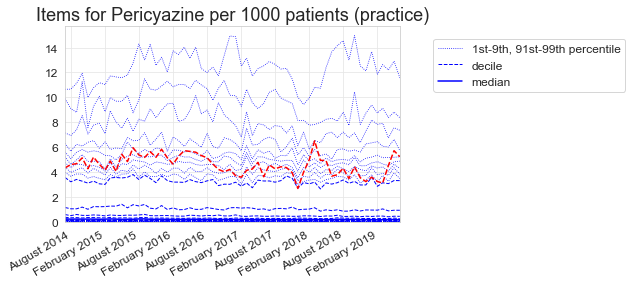

In [7]:
#create sample deciles chart
charts.deciles_chart(
        pericyazine_per_1000,
        period_column='month',
        column='pericyazine_per_1000',
        title="Items for Pericyazine per 1000 patients (practice)",
        show_outer_percentiles=True)

#add in example https://openprescribing.net/practice/D82099/ from West Norfolk
df_subject = pericyazine_per_1000.loc[pericyazine_per_1000['practice'] == 'D82099']
plt.plot(df_subject['month'], df_subject['pericyazine_per_1000'], 'r--')
plt.show()

In [8]:
ccg_pericyazine = pericyazine_per_1000.groupby(['pct', 'month']).sum().reset_index()
ccg_pericyazine.head(5)

,pct,month,address5,total_pericyazine,list_size,pericyazine_per_1000
0,00C,2014-07-01,0.0,2,21934,0.183544
1,00C,2014-08-01,0.0,4,35872,0.354418
2,00C,2014-09-01,0.0,3,35872,0.255291
3,00C,2014-10-01,0.0,3,35915,0.255065
4,00C,2014-11-01,0.0,4,35915,0.354143


In [9]:
ccg_pericyazine["pericyazine_per_1000"] = 1000*(ccg_pericyazine.total_pericyazine / ccg_pericyazine.list_size).fillna(0)
ccg_pericyazine.head(5)

,pct,month,address5,total_pericyazine,list_size,pericyazine_per_1000
0,00C,2014-07-01,0.0,2,21934,0.091183
1,00C,2014-08-01,0.0,4,35872,0.111508
2,00C,2014-09-01,0.0,3,35872,0.083631
3,00C,2014-10-01,0.0,3,35915,0.083531
4,00C,2014-11-01,0.0,4,35915,0.111374


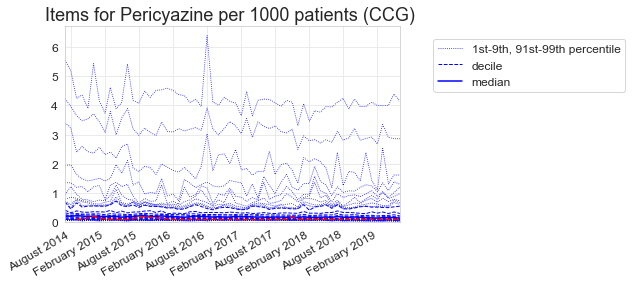

In [10]:
#create sample deciles chart
charts.deciles_chart(
        ccg_pericyazine,
        period_column='month',
        column='pericyazine_per_1000',
        title="Items for Pericyazine per 1000 patients (CCG) ",
        show_outer_percentiles=True)

#add in example Islington is 08H
df_subject = ccg_pericyazine.loc[ccg_pericyazine['pct'] == '08H']
plt.plot(df_subject['month'], df_subject['pericyazine_per_1000'], 'r--')
plt.show()

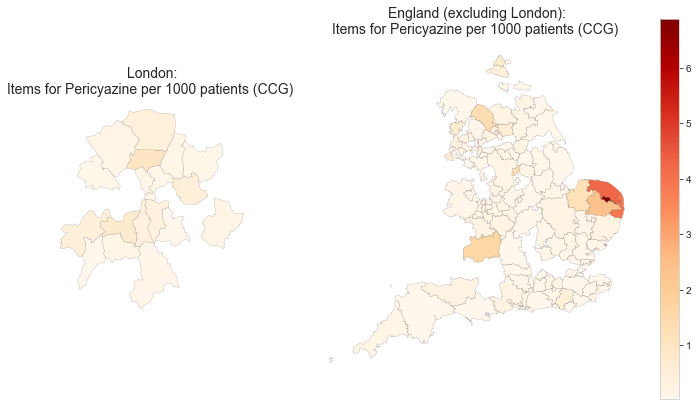

In [11]:
#create choropeth map of cost per 1000 patients
latest_ccg = ccg_pericyazine.loc[(ccg_pericyazine["month"] == "2019-06-01")]
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(
    latest_ccg, 
    title="Items for Pericyazine per 1000 patients (CCG) ", 
    column='pericyazine_per_1000', separate_london=True)
plt.show()

In [12]:
## here we look at CCGs thatare outliers.
latest_ccg.sort_values("total_pericyazine", ascending=False).head(10)

,pct,month,address5,total_pericyazine,list_size,pericyazine_per_1000
4258,06W,2019-06-01,0.0,1638,237871,6.886085
3944,06M,2019-06-01,0.0,953,240292,3.966008
4198,06V,2019-06-01,0.0,739,174233,4.241447
4318,06Y,2019-06-01,0.0,551,231406,2.381096
4460,07J,2019-06-01,0.0,194,164220,1.181342
7071,15F,2019-06-01,0.0,57,93646,0.608675
3884,06L,2019-06-01,0.0,54,198080,0.272617
7056,15E,2019-06-01,0.0,42,308938,0.135950
6745,11M,2019-06-01,0.0,36,22116,1.627781
6805,11N,2019-06-01,0.0,36,198218,0.181618
